## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 

## Arguments & Initializations

In [5]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [6]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [7]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [8]:
DATASET = "law_sex"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [9]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 3 

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

egr_metrics = defaultdict(list) 
egr_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [10]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

In [11]:
dataset_orig.features.shape

(22342, 4)

In [12]:
privileged_groups

[{'gender': 1}]

In [13]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[1.         1.         0.83783784 1.        ]
 [1.         0.         0.72972973 0.85      ]
 [1.         1.         0.78378378 0.95      ]
 ...
 [1.         1.         0.94594595 0.875     ]
 [1.         0.         0.67567568 0.975     ]
 [1.         1.         0.91891892 0.75      ]]


In [14]:
# NOT SUITABLE
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [15]:
dataset_orig_train

               instance weights features                                       \
                                         protected attribute                    
                                    race              gender      lsat   ugpa   
instance names                                                                  
4835                        1.0      1.0                 1.0  0.837838  1.000   
20806                       1.0      1.0                 0.0  0.729730  0.850   
10099                       1.0      1.0                 1.0  0.783784  0.950   
8612                        1.0      1.0                 1.0  0.648649  0.550   
13350                       1.0      1.0                 1.0  0.486486  0.900   
...                         ...      ...                 ...       ...    ...   
22212                       1.0      1.0                 1.0  0.864865  0.900   
7796                        1.0      1.0                 1.0  0.729730  0.750   
4847                        

In [16]:
dataset_orig_train?

## Run Mitigating Algorithms

In [17]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    # egr_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
    egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

#### Train dataset's features are as below:
[[1.         1.         0.51351351 0.575     ]
 [1.         1.         0.72972973 0.7       ]
 [1.         0.         0.78378378 0.775     ]
 ...
 [1.         1.         0.67567568 0.775     ]
 [1.         0.         0.78378378 0.875     ]
 [1.         0.         0.64864865 0.925     ]]
no bias type specified
#### Training Dataset shape
(11171, 4)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['gender']
#### Privileged and unprivileged protected groups
[{'gender': 1}] [{'gender': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'gender', 'lsat', 'ugpa']
privileged vs. unprivileged:  6340.0 4831.0
base_pos unpriv:  0.27985924239287935
base_pos priv:  0.3085173501577287
number of favorable labels:  3308
Difference in mean outcomes between unprivileged and privileged groups = -0.028658
#### Train shape, validation shape, test shape
(1117

Accuracy for threshold: 0.01  is: 0.36997583027481873
Balanced accuracy is:  0.5388519785180508
Accuracy for threshold: 0.02  is: 0.36997583027481873
Balanced accuracy is:  0.5388519785180508
Accuracy for threshold: 0.03  is: 0.36997583027481873
Balanced accuracy is:  0.5388519785180508
Accuracy for threshold: 0.04  is: 0.36997583027481873
Balanced accuracy is:  0.5388519785180508
Accuracy for threshold: 0.05  is: 0.36997583027481873
Balanced accuracy is:  0.5388519785180508
Accuracy for threshold: 0.060000000000000005  is: 0.3710500402828753
Balanced accuracy is:  0.5393784661332076
Accuracy for threshold: 0.06999999999999999  is: 0.378032405335243
Balanced accuracy is:  0.5431705485847163
Accuracy for threshold: 0.08  is: 0.3793751678453138
Balanced accuracy is:  0.544054716019378
Accuracy for threshold: 0.09  is: 0.3823292453674693
Balanced accuracy is:  0.5458519191944382
Accuracy for threshold: 0.09999999999999999  is: 0.3825977978694835
Balanced accuracy is:  0.546045193257059
Ac

[INFO]: training decision tree
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83      7863
         1.0       0.67      0.11      0.19      3308

    accuracy                           0.72     11171
   macro avg       0.70      0.54      0.51     11171
weighted avg       0.71      0.72      0.64     11171

Train accuracy:  0.7207053979052905
Validating Original ...
Accuracy for threshold: 0.01  is: 0.3849252528869394
Balanced accuracy is:  0.5333347314057316
Accuracy for threshold: 0.02  is: 0.3893116104198371
Balanced accuracy is:  0.5364915410952046
Accuracy for threshold: 0.03  is: 0.3893116104198371
Balanced accuracy is:  0.5364915410952046
Accuracy for threshold: 0.04  is: 0.39342941545072063
Balanced accuracy is:  0.5388796565729619
Accuracy for threshold: 0.05  is: 0.39342941545072063
Balanced accuracy is:  0.5388796565729619
Accuracy for threshold: 0.060000000000000005  is: 0.

Accuracy for threshold: 0.13  is: 0.39897950049234626
Balanced accuracy is:  0.5505188548955772
Accuracy for threshold: 0.14  is: 0.3995166054963745
Balanced accuracy is:  0.5503299828717239
Accuracy for threshold: 0.15000000000000002  is: 0.4098111180735834
Balanced accuracy is:  0.5561769672484538
Accuracy for threshold: 0.16  is: 0.4167039656252797
Balanced accuracy is:  0.5593292048633272
Accuracy for threshold: 0.17  is: 0.4262823381971175
Balanced accuracy is:  0.5621125025080286
Accuracy for threshold: 0.18000000000000002  is: 0.4468713633515352
Balanced accuracy is:  0.5673946467430014
Accuracy for threshold: 0.19  is: 0.4488407483663056
Balanced accuracy is:  0.5677433524491394
Accuracy for threshold: 0.2  is: 0.45662877092471577
Balanced accuracy is:  0.571293228304089
Accuracy for threshold: 0.21000000000000002  is: 0.46522245098916837
Balanced accuracy is:  0.5720526083307733
Accuracy for threshold: 0.22  is: 0.46719183600393877
Balanced accuracy is:  0.5712504737387214
Acc

Accuracy for threshold: 0.12  is: 0.38975919792319397
Balanced accuracy is:  0.5466780099459626
Accuracy for threshold: 0.13  is: 0.399158535493689
Balanced accuracy is:  0.5507299071490999
Accuracy for threshold: 0.14  is: 0.39969564049771733
Balanced accuracy is:  0.5505410351252465
Accuracy for threshold: 0.15000000000000002  is: 0.40999015307492614
Balanced accuracy is:  0.5563880195019764
Accuracy for threshold: 0.16  is: 0.4168830006266225
Balanced accuracy is:  0.5595402571168497
Accuracy for threshold: 0.17  is: 0.4264613731984603
Balanced accuracy is:  0.5623235547615512
Accuracy for threshold: 0.18000000000000002  is: 0.44705039835287796
Balanced accuracy is:  0.5676056989965241
Accuracy for threshold: 0.19  is: 0.44901978336764836
Balanced accuracy is:  0.5679544047026621
Accuracy for threshold: 0.2  is: 0.4568078059260585
Balanced accuracy is:  0.5715042805576117
Accuracy for threshold: 0.21000000000000002  is: 0.4654014859905111
Balanced accuracy is:  0.572263660584296
Acc

Accuracy for threshold: 0.24000000000000002  is: 0.4890341061677558
Balanced accuracy is:  0.5753369096780826
Accuracy for threshold: 0.25  is: 0.5121296213409722
Balanced accuracy is:  0.5814990509013185
Accuracy for threshold: 0.26  is: 0.5220660639154955
Balanced accuracy is:  0.5837217116509843
Accuracy for threshold: 0.27  is: 0.5390743890430579
Balanced accuracy is:  0.5871281872530952
Accuracy for threshold: 0.28  is: 0.5624384567182884
Balanced accuracy is:  0.5864835404976037
Accuracy for threshold: 0.29000000000000004  is: 0.5680780592605854
Balanced accuracy is:  0.5863889996620878
Accuracy for threshold: 0.3  is: 0.5728224867961687
Balanced accuracy is:  0.5880147215869407
Accuracy for threshold: 0.31  is: 0.5763136693223525
Balanced accuracy is:  0.5872253721884373
Accuracy for threshold: 0.32  is: 0.5986930444901978
Balanced accuracy is:  0.585707126263718
Accuracy for threshold: 0.33  is: 0.6069286545519649
Balanced accuracy is:  0.5855315884709333
Accuracy for threshold

Accuracy for threshold: 0.34  is: 0.630203204726524
Balanced accuracy is:  0.5865936986421654
Accuracy for threshold: 0.35000000000000003  is: 0.6430937248232029
Balanced accuracy is:  0.5811494019883174
Accuracy for threshold: 0.36000000000000004  is: 0.6490913973681854
Balanced accuracy is:  0.5778538454228045
Accuracy for threshold: 0.37  is: 0.6551785874138394
Balanced accuracy is:  0.5730201836504236
Accuracy for threshold: 0.38  is: 0.6634141974756065
Balanced accuracy is:  0.5717484096785772
Accuracy for threshold: 0.39  is: 0.6645779249843344
Balanced accuracy is:  0.5643175951185428
Accuracy for threshold: 0.4  is: 0.6651150299883627
Balanced accuracy is:  0.5609917740722843
Accuracy for threshold: 0.41000000000000003  is: 0.6666368274997762
Balanced accuracy is:  0.555082191938212
Accuracy for threshold: 0.42000000000000004  is: 0.6681586250111897
Balanced accuracy is:  0.5476547443254384
Accuracy for threshold: 0.43  is: 0.6684271775132038
Balanced accuracy is:  0.5467507665

Accuracy for threshold: 0.25  is: 0.48876555366574165
Balanced accuracy is:  0.5739640892438096
Accuracy for threshold: 0.26  is: 0.5011189687583922
Balanced accuracy is:  0.575640277332973
Accuracy for threshold: 0.27  is: 0.51069734133023
Balanced accuracy is:  0.5769319866761717
Accuracy for threshold: 0.28  is: 0.5311968489839763
Balanced accuracy is:  0.5794647870198514
Accuracy for threshold: 0.29000000000000004  is: 0.5463253065974398
Balanced accuracy is:  0.5800919142362063
Accuracy for threshold: 0.3  is: 0.5577835466833766
Balanced accuracy is:  0.5807056117081197
Accuracy for threshold: 0.31  is: 0.574791871810939
Balanced accuracy is:  0.5800644460336943
Accuracy for threshold: 0.32  is: 0.6036165070271238
Balanced accuracy is:  0.5807992775177937
Accuracy for threshold: 0.33  is: 0.6056754095425656
Balanced accuracy is:  0.5758644931937826
Accuracy for threshold: 0.34  is: 0.6299346522245098
Balanced accuracy is:  0.5712227854598706
Accuracy for threshold: 0.3500000000000

Accuracy for threshold: 0.47000000000000003  is: 0.6888371676662788
Balanced accuracy is:  0.5347997587059174
Accuracy for threshold: 0.48000000000000004  is: 0.6895533076716498
Balanced accuracy is:  0.5307588513239027
Accuracy for threshold: 0.49  is: 0.6895533076716498
Balanced accuracy is:  0.5307588513239027
Accuracy for threshold: 0.5  is: 0.6918807626891057
Balanced accuracy is:  0.5280401460334432
Best thresh:  0.31
Best balanced accuracy: 0.5280
Corresponding 1-min(DI, 1/DI) value: 0.6749
Corresponding average odds difference value: 0.0421
Corresponding statistical parity difference value: 0.0303
Corresponding equal opportunity difference value: 0.0669
Corresponding Theil index value: 0.3295
Corresponding false positive_rate for privileged: 0.0515
Corresponding false negative_rate for privileged: 0.9120
Corresponding false positive_rate for unpribileged: 0.0687
Corresponding false negative_rate for unprivileged: 0.8451
Testing Original ...
True positive rate is:  0.59542891065

Accuracy for threshold: 0.45  is: 0.6850774326380807
Balanced accuracy is:  0.5408780306044473
Accuracy for threshold: 0.46  is: 0.6854355026407662
Balanced accuracy is:  0.5402911165322133
Accuracy for threshold: 0.47000000000000003  is: 0.688658132664936
Balanced accuracy is:  0.5344186088626117
Accuracy for threshold: 0.48000000000000004  is: 0.689374272670307
Balanced accuracy is:  0.5303777014805969
Accuracy for threshold: 0.49  is: 0.689374272670307
Balanced accuracy is:  0.5303777014805969
Accuracy for threshold: 0.5  is: 0.6917912451884344
Balanced accuracy is:  0.5278074081818265
Best thresh:  0.31
Best balanced accuracy: 0.5278
Corresponding 1-min(DI, 1/DI) value: 0.6603
Corresponding average odds difference value: 0.0438
Corresponding statistical parity difference value: 0.0319
Corresponding equal opportunity difference value: 0.0691
Corresponding Theil index value: 0.3297
Corresponding false positive_rate for privileged: 0.0508
Corresponding false negative_rate for privileg

Accuracy for threshold: 0.23  is: 0.4837525736281443
Balanced accuracy is:  0.5730736933828796
Accuracy for threshold: 0.24000000000000002  is: 0.4890341061677558
Balanced accuracy is:  0.5753369096780826
Accuracy for threshold: 0.25  is: 0.5121296213409722
Balanced accuracy is:  0.5814990509013185
Accuracy for threshold: 0.26  is: 0.5220660639154955
Balanced accuracy is:  0.5837217116509843
Accuracy for threshold: 0.27  is: 0.5390743890430579
Balanced accuracy is:  0.5871281872530952
Accuracy for threshold: 0.28  is: 0.5624384567182884
Balanced accuracy is:  0.5864835404976037
Accuracy for threshold: 0.29000000000000004  is: 0.5680780592605854
Balanced accuracy is:  0.5863889996620878
Accuracy for threshold: 0.3  is: 0.5728224867961687
Balanced accuracy is:  0.5880147215869407
Accuracy for threshold: 0.31  is: 0.5763136693223525
Balanced accuracy is:  0.5872253721884373
Accuracy for threshold: 0.32  is: 0.5986930444901978
Balanced accuracy is:  0.585707126263718
Accuracy for threshold

Accuracy for threshold: 0.35000000000000003  is: 0.6430937248232029
Balanced accuracy is:  0.5811494019883174
Accuracy for threshold: 0.36000000000000004  is: 0.6490913973681854
Balanced accuracy is:  0.5778538454228045
Accuracy for threshold: 0.37  is: 0.6551785874138394
Balanced accuracy is:  0.5730201836504236
Accuracy for threshold: 0.38  is: 0.6634141974756065
Balanced accuracy is:  0.5717484096785772
Accuracy for threshold: 0.39  is: 0.6645779249843344
Balanced accuracy is:  0.5643175951185428
Accuracy for threshold: 0.4  is: 0.6651150299883627
Balanced accuracy is:  0.5609917740722843
Accuracy for threshold: 0.41000000000000003  is: 0.6666368274997762
Balanced accuracy is:  0.555082191938212
Accuracy for threshold: 0.42000000000000004  is: 0.6681586250111897
Balanced accuracy is:  0.5476547443254384
Accuracy for threshold: 0.43  is: 0.6684271775132038
Balanced accuracy is:  0.5467507665416598
Accuracy for threshold: 0.44  is: 0.6820338376152538
Balanced accuracy is:  0.542915395

Protected_attr_val, label, 0.0 1.0
Protected_attr_val, label, 1.0 0.0
Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.05
  Positive predictive value: 0.54
  Optimal thershold: -0.34830669426821587
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7822, Test = 7802
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.07
  Positive predictive value: 0.54
  Optimal thershold: -0.34830669426821587
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3349, Test = 3369
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.11
  Positive predictive value: 0.60
  Optimal thershold: -1.10583

Protected_attr_val, label, 0.0 1.0
Protected_attr_val, label, 1.0 0.0
Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.18
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -1.0324590411615882
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7822, Test = 7802
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.51
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -0.309326433895757
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3349, Test = 3369
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.08
  Positive predictive value: 0.65
  Optimal thershold: -1.04346759

Protected_attr_val, label, 0.0 1.0
Protected_attr_val, label, 1.0 0.0
Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.18
  Attacker advantage: 0.03
  Positive predictive value: 0.55
  Optimal thershold: -1.0324590411615882
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7822, Test = 7802
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -0.309326433895757
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3349, Test = 3369
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.08
  Positive predictive value: 0.66
  Optimal thershold: -1.04346759

## Display Output

In [18]:
priv_metric_orig_copy = priv_metric_orig

In [19]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 18850.0, 'total_unpriv': 14663.0})

In [20]:
priv_metric_orig

defaultdict(float, {'total_priv': 18850.0, 'total_unpriv': 14663.0})

In [21]:
priv_metric_orig = priv_metric_orig_copy

1)

law_sex
11171
2)

               total_priv  total_unpriv
num_instance                           
orig          6283.333333   4887.666667
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.298571       0.701429    0.307475      0.692525      0.287075   
transf      0.307454       0.692546    0.307475      0.692525      0.307427   

         unpriv_unfavor  
dataset                  
orig           0.712925  
transf         0.692573  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.588096      -0.057748  0.130958      -0.071532   
dt_syn                     0.523428       0.037676  0.359852       0.031054   
dt_dir                     0.580622      -0.021989  0.128688      -0.034650   
dt_rew                     0.58785

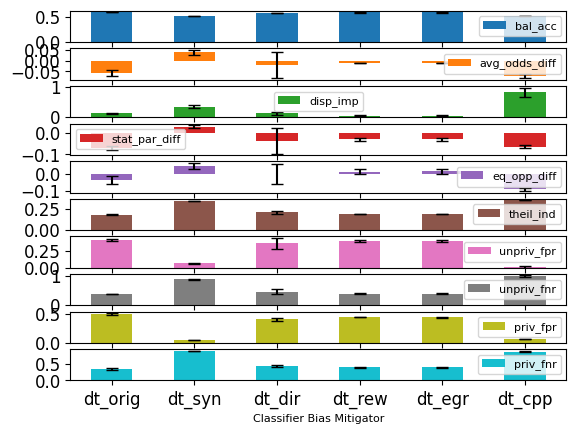

In [22]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

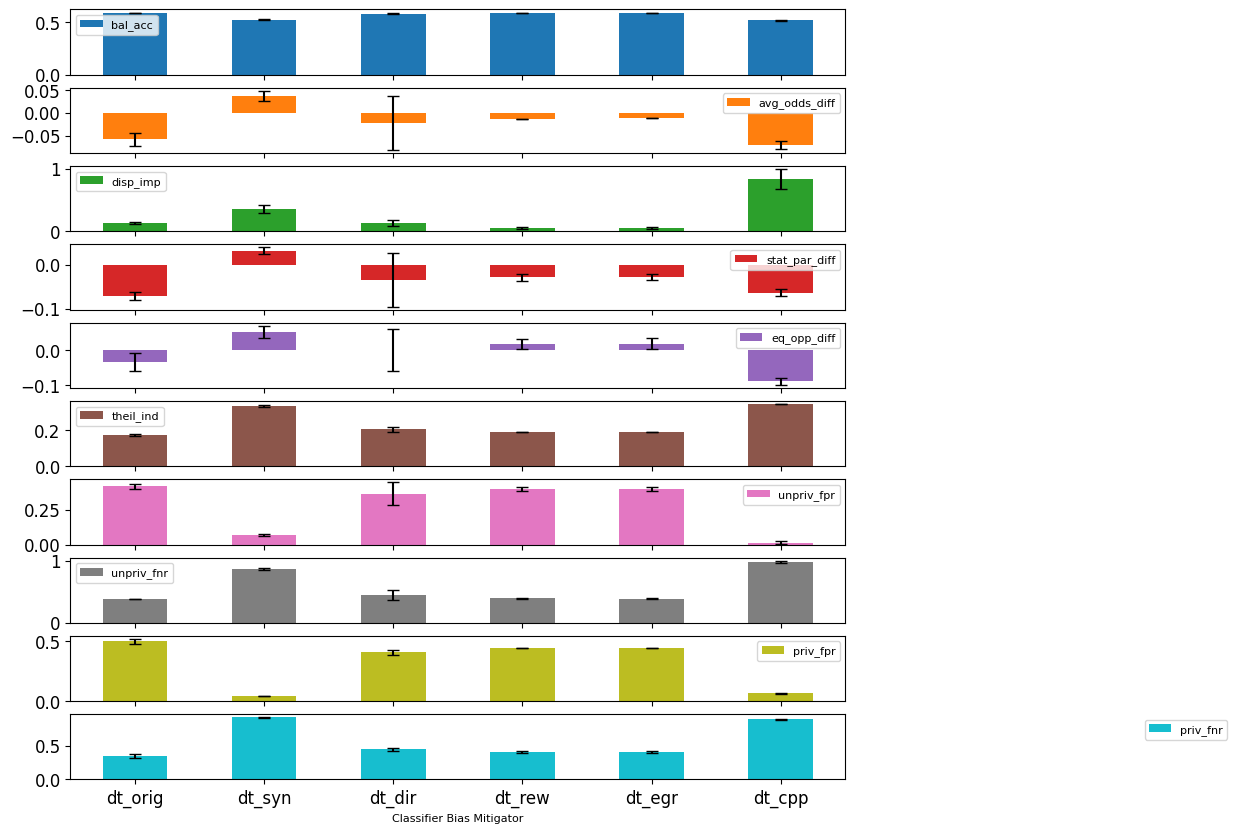

In [23]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [24]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.588096,-0.057748,0.130958,-0.071532,-0.034323,0.175959,0.415238,0.383217,0.496411,0.348894
dt_syn,0.523428,0.037676,0.359852,0.031054,0.051092,0.335641,0.067143,0.869413,0.042883,0.920505
dt_dir,0.580622,-0.021989,0.128688,-0.034650,-0.000357,0.204436,0.364341,0.450578,0.407963,0.450221
dt_rew,0.587858,-0.012804,0.059315,-0.028873,0.016171,0.188951,0.398259,0.393054,0.440038,0.409225
dt_egr,0.587674,-0.011317,0.056804,-0.027602,0.018222,0.189119,0.398648,0.392337,0.439503,0.410559
dt_cpp,0.514737,-0.070565,0.831326,-0.063696,-0.089260,0.344512,0.012021,0.982042,0.063890,0.892782


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [25]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [26]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.518127,0.516337,0.539742,0.516847,0.538456,0.520209,0.541680
syn,0.516397,0.513437,0.535031,0.514265,0.534813,0.516592,0.537784
dir,0.527392,0.534218,0.557650,0.527811,0.559790,0.549781,0.559421
rew,0.517247,0.515618,0.540429,0.512354,0.540935,0.520336,0.541072


In [27]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [28]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [29]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.516847,0.538456,0.520209,0.541680
syn,0.514265,0.534813,0.516592,0.537784
dir,0.527811,0.559790,0.549781,0.559421
rew,0.512354,0.540935,0.520336,0.541072


<Axes: xlabel='Classifier MIA Attacks'>

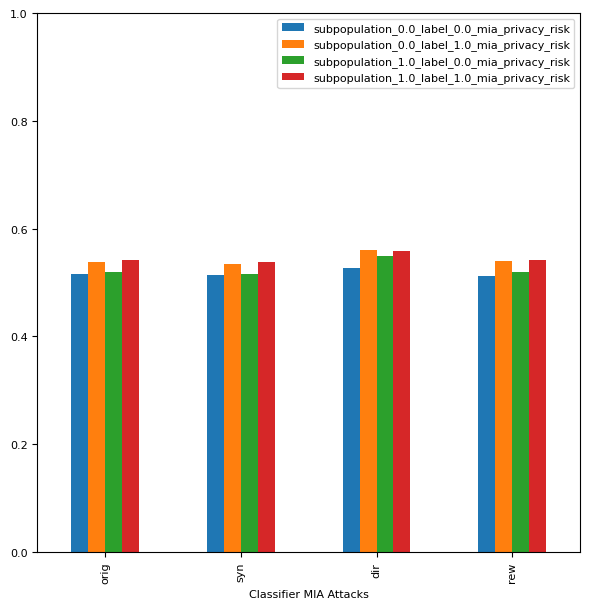

In [30]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [31]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew
--------------------------------------------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.516847  0.514265  0.527811  0.512354
subpopulation_0.0_label_1.0_mia_privacy_risk  0.538456  0.534813  0.55979   0.540935
subpopulation_1.0_label_0.0_mia_privacy_risk  0.520209  0.516592  0.549781  0.520336
subpopulation_1.0_label_1.0_mia_privacy_risk  0.54168   0.537784  0.559421  0.541072


### Visualizing using novel technique

In [100]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [101]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])

In [102]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.525092
1,orig,entire_dataset_mia_privacy_risk,0.522074
2,orig,entire_dataset_mia_privacy_risk,0.522074
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.514056
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.512911
...,...,...,...
79,dir,subpopulation_1.0_label_0.0_mia_privacy_risk,0.510875
80,dir,subpopulation_1.0_label_0.0_mia_privacy_risk,0.510875
81,dir,subpopulation_1.0_label_1.0_mia_privacy_risk,0.595733
82,dir,subpopulation_1.0_label_1.0_mia_privacy_risk,0.585712


In [103]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.525092
1,orig,entire_dataset_mia_privacy_risk,0.522074
2,orig,entire_dataset_mia_privacy_risk,0.522074
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.533545
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.546109
11,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.546109
12,orig,subpopulation_0.0_label_1.0_mia_privacy_risk,0.628333
13,orig,subpopulation_0.0_label_1.0_mia_privacy_risk,0.628065
14,orig,subpopulation_0.0_label_1.0_mia_privacy_risk,0.628065
15,orig,subpopulation_1.0_label_0.0_mia_privacy_risk,0.513932


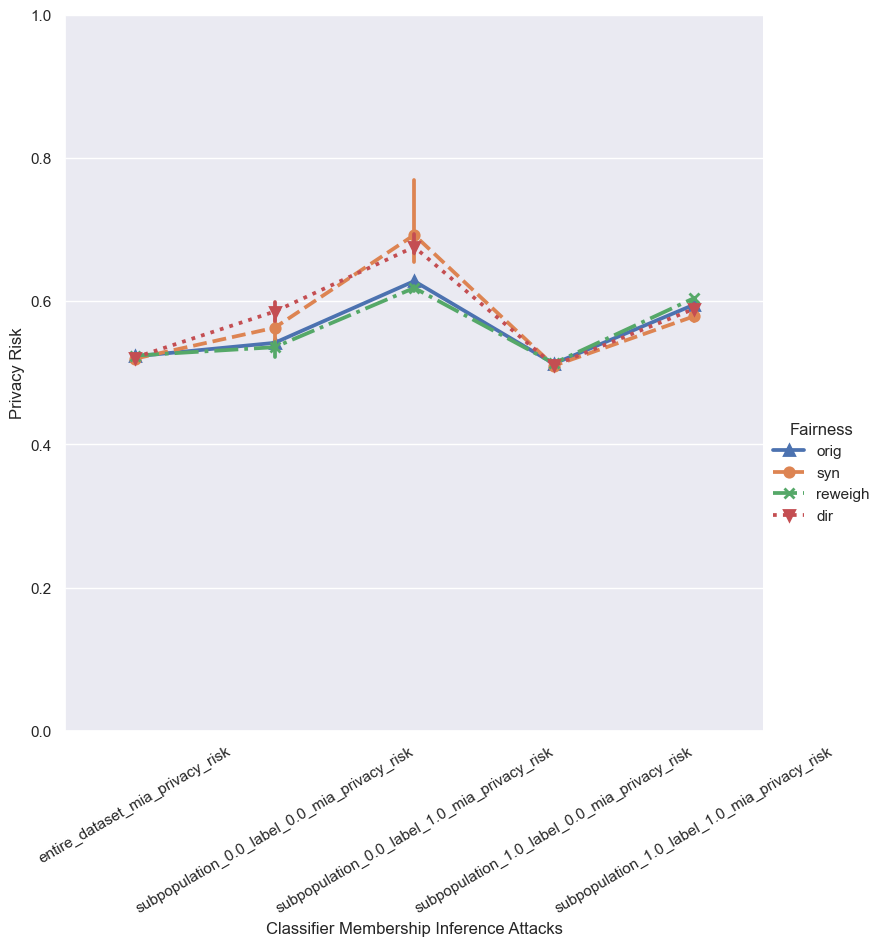

In [104]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [105]:
from sklearn.metrics import RocCurveDisplay, auc

In [106]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

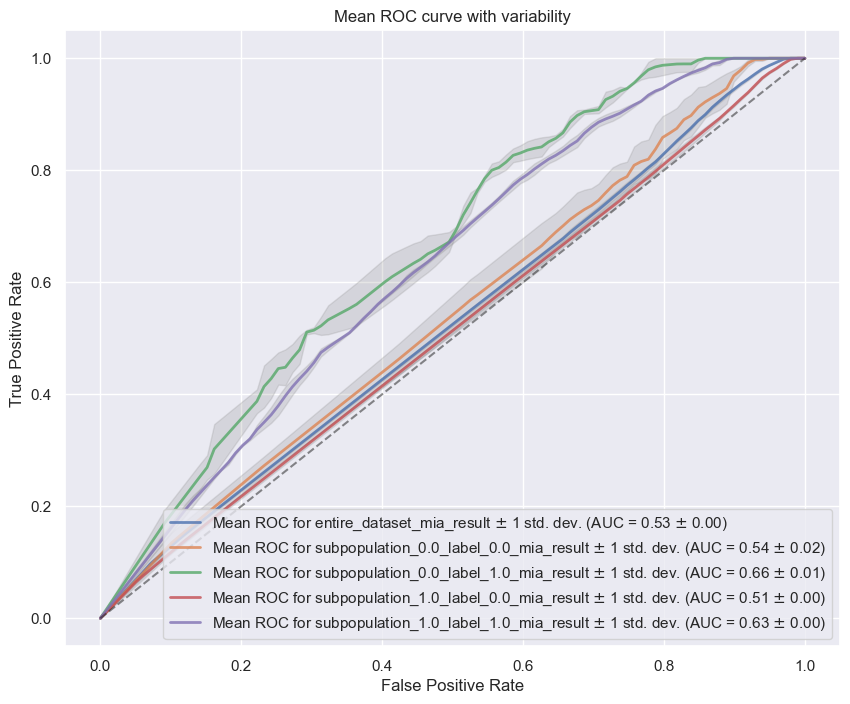

In [107]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

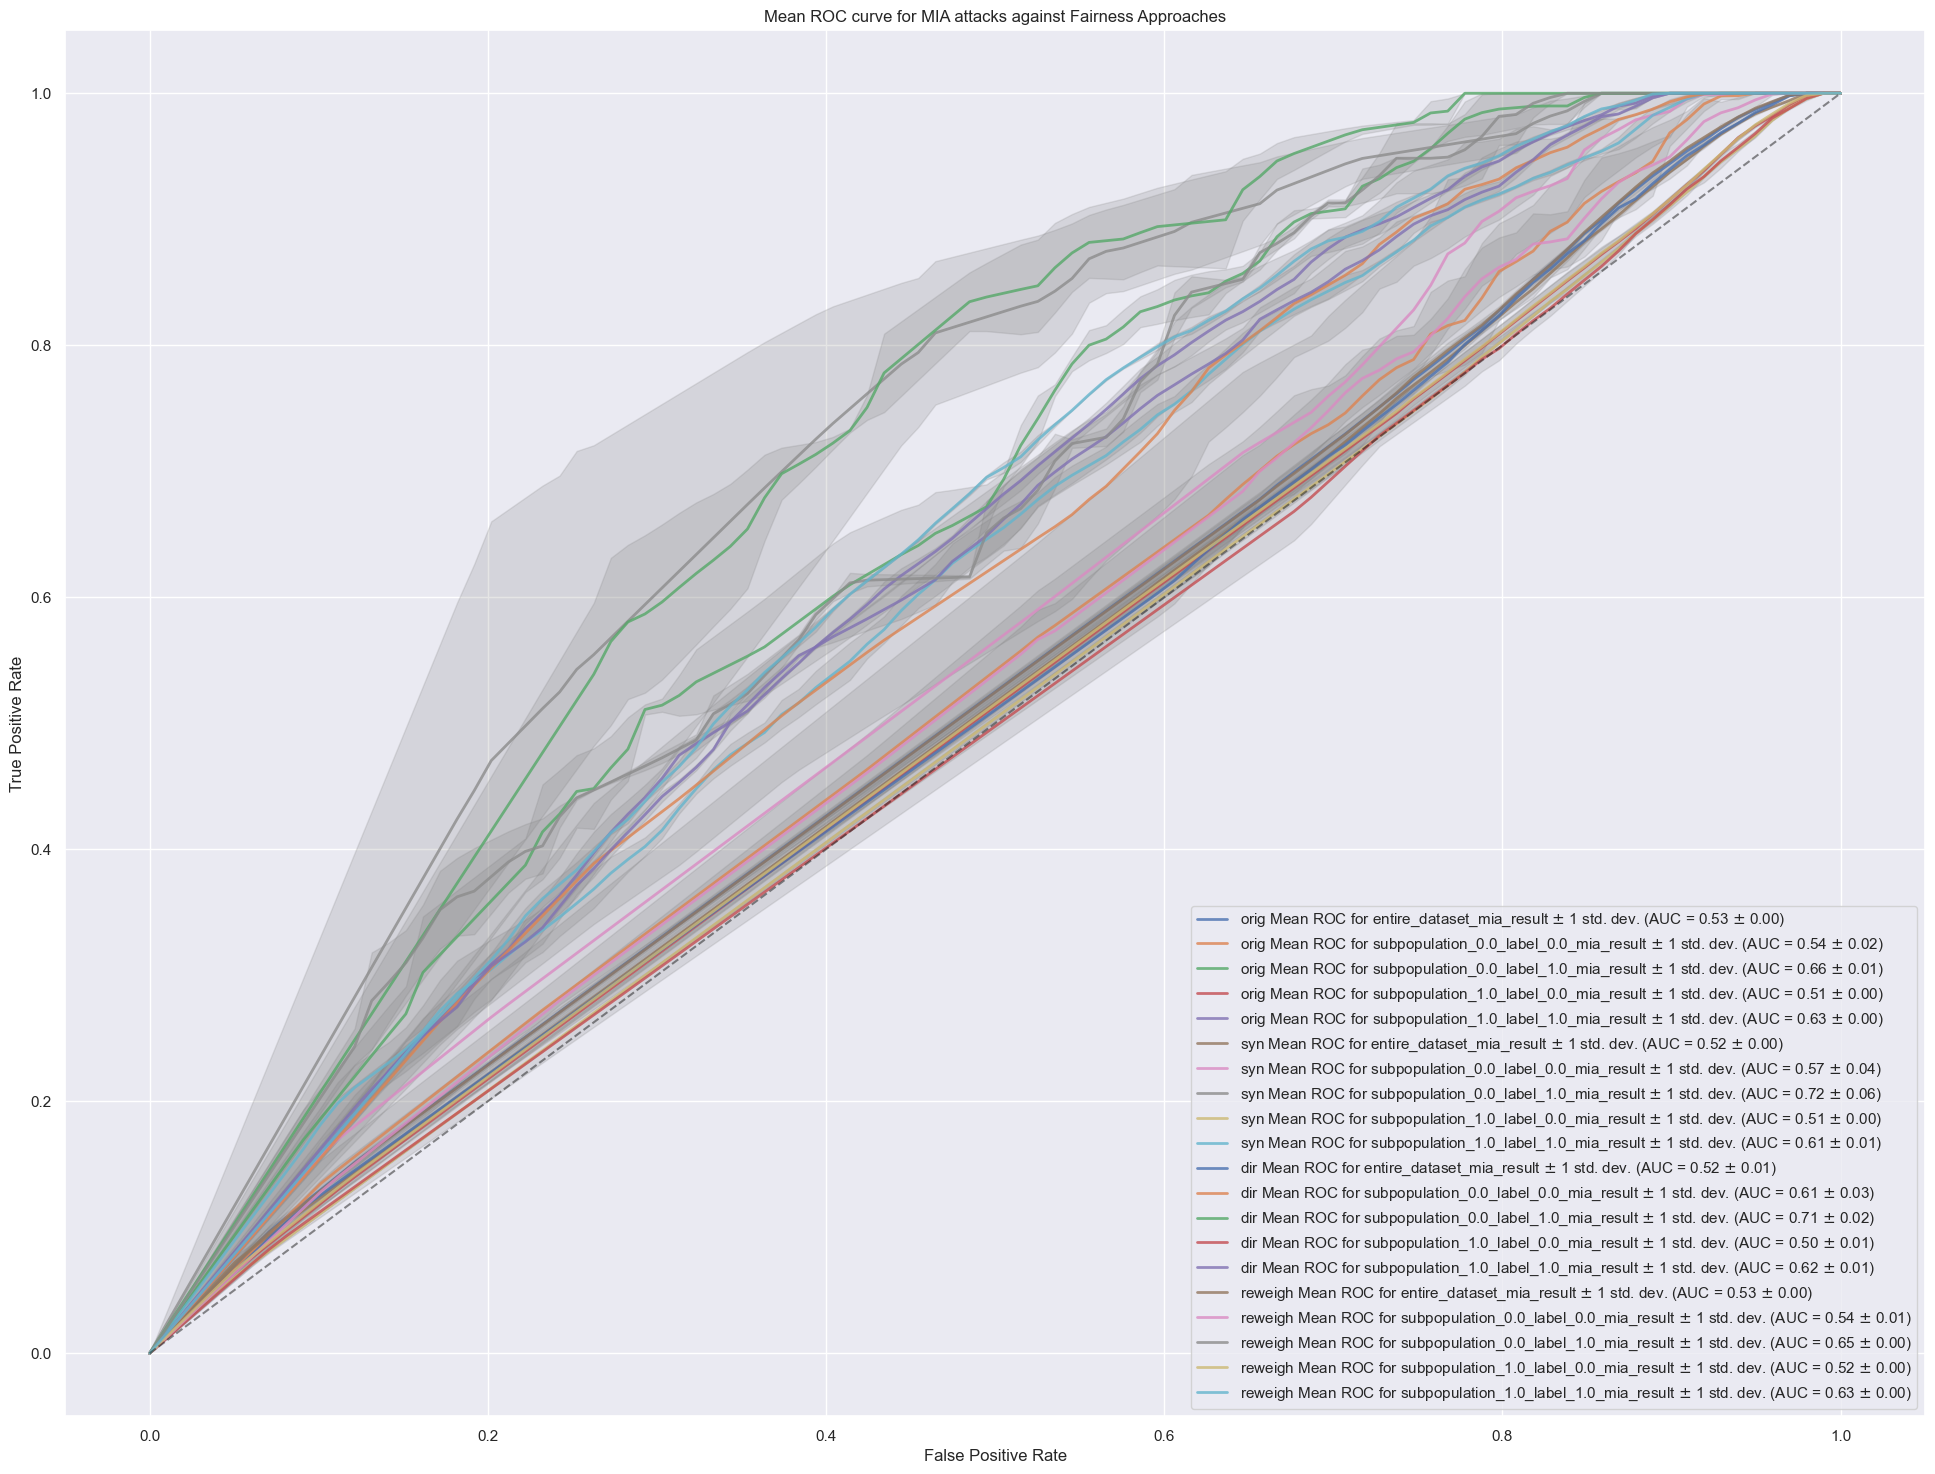

In [108]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

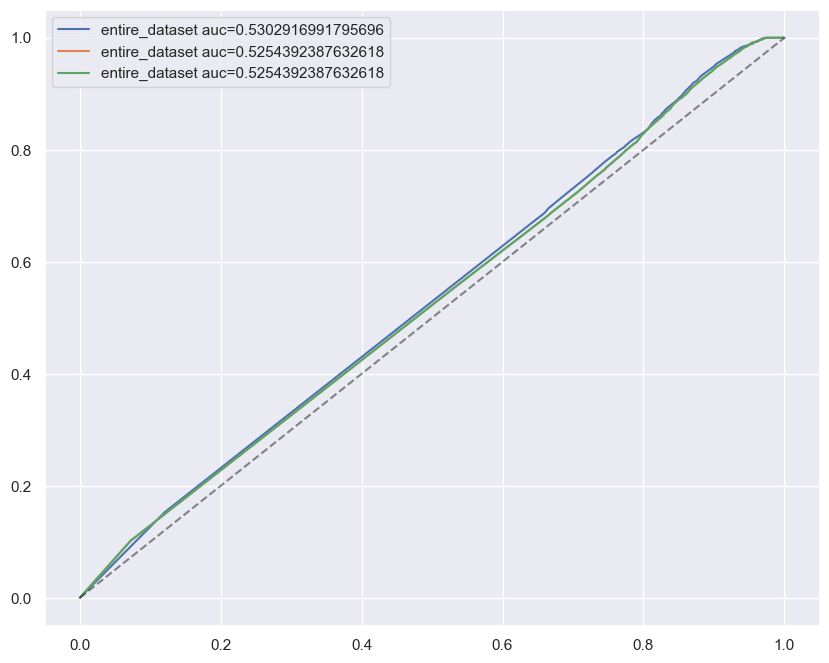

In [109]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [110]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}

In [111]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5270567255686978,
 'entire_dataset_label_0.0_mia_auc': 0.5148156799696316,
 'entire_dataset_label_1.0_mia_auc': 0.6294052003271392,
 'subpopulation_0.0_label_0.0_mia_auc': 0.5408190544338648,
 'subpopulation_0.0_label_1.0_mia_auc': 0.6581837626518477,
 'subpopulation_1.0_label_0.0_mia_auc': 0.514148027860466,
 'subpopulation_1.0_label_1.0_mia_auc': 0.627883459343571}

In [112]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.527057,0.514816,0.629405,0.540819,0.658184,0.514148,0.627883
syn,0.520672,0.507990,0.617270,0.565038,0.717232,0.506316,0.609731
dir,0.519026,0.506472,0.622829,0.607357,0.714493,0.503434,0.617612
rew,0.527094,0.516104,0.635453,0.538592,0.649899,0.515513,0.634712


<Axes: xlabel='Classifier MIA Attacks'>

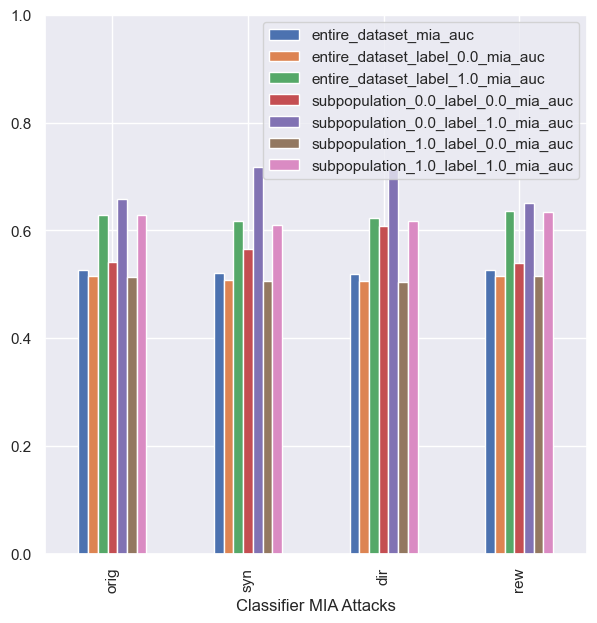

In [113]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [114]:
# Creating data structures to plot point categorical plot from seaborn

In [115]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}

In [116]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.05018367882445551,
  0.044148517449488334,
  0.044148517449488334],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.028111521419503793,
  0.025821590364842772,
  0.025821590364842772],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.20252734662995375,
  0.1864243139302857,
  0.1864243139302857],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.06708908952463832,
  0.09221701102801372,
  0.09221701102801372],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.25666666666666665,
  0.25612968591691987,
  0.25612968591691987],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.027864049557353998,
  0.02425695461893418,
  0.02425695461893418],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.20116458187155728,
  0.18420743743375112,
  0.18420743743375112]}

In [117]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.05018367882445551],
 ['orig', 'entire_dataset', 0.044148517449488334],
 ['orig', 'entire_dataset', 0.044148517449488334],
 ['orig', 'entire_dataset_label_0.0', 0.028111521419503793],
 ['orig', 'entire_dataset_label_0.0', 0.025821590364842772],
 ['orig', 'entire_dataset_label_0.0', 0.025821590364842772],
 ['orig', 'entire_dataset_label_1.0', 0.20252734662995375],
 ['orig', 'entire_dataset_label_1.0', 0.1864243139302857],
 ['orig', 'entire_dataset_label_1.0', 0.1864243139302857],
 ['orig', 'subpopulation_0.0_label_0.0', 0.06708908952463832],
 ['orig', 'subpopulation_0.0_label_0.0', 0.09221701102801372],
 ['orig', 'subpopulation_0.0_label_0.0', 0.09221701102801372],
 ['orig', 'subpopulation_0.0_label_1.0', 0.25666666666666665],
 ['orig', 'subpopulation_0.0_label_1.0', 0.25612968591691987],
 ['orig', 'subpopulation_0.0_label_1.0', 0.25612968591691987],
 ['orig', 'subpopulation_1.0_label_0.0', 0.027864049557353998],
 ['orig', 'subpopulation_1.0_label_0.0', 0.02

In [118]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.050184
1,orig,entire_dataset,0.044149
2,orig,entire_dataset,0.044149
3,orig,entire_dataset_label_0.0,0.028112
4,orig,entire_dataset_label_0.0,0.025822
...,...,...,...
79,dir,subpopulation_1.0_label_0.0,0.021749
80,dir,subpopulation_1.0_label_0.0,0.021749
81,dir,subpopulation_1.0_label_1.0,0.191466
82,dir,subpopulation_1.0_label_1.0,0.171424


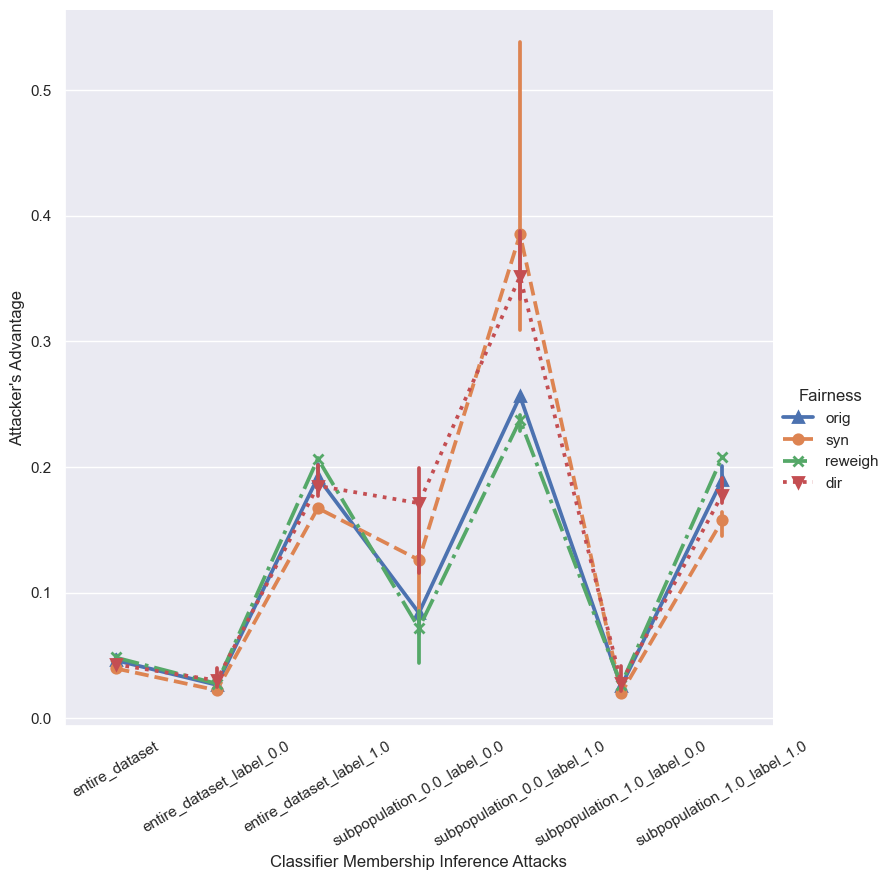

In [119]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


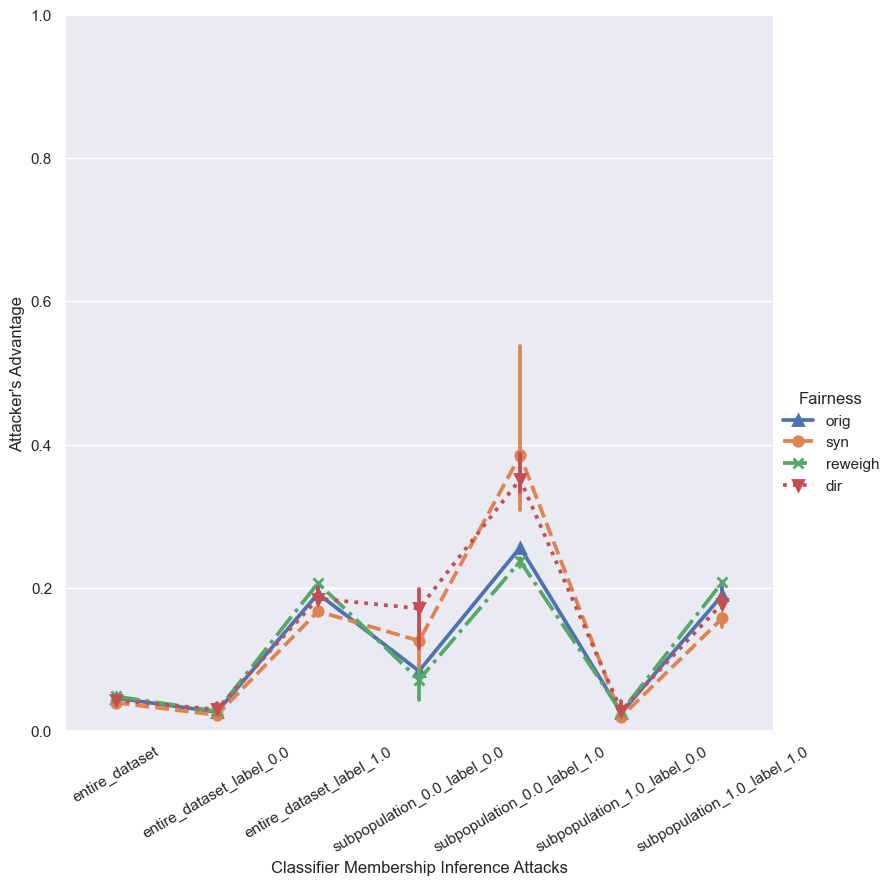

In [120]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [121]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.050184,0.028112,0.202527,0.067089,0.256667,0.027864,0.201165
1,0.044149,0.025822,0.186424,0.092217,0.256130,0.024257,0.184207
2,0.044149,0.025822,0.186424,0.092217,0.256130,0.024257,0.184207


In [122]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}


In [123]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.04616023790781073,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.026584900716396447,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.1917919914968417,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.08384103719355525,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.25630867950016883,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.025459319598407453,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.18985981891301984}

In [124]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.046160,0.026585,0.191792,0.083841,0.256309,0.025459,0.189860
syn,0.039666,0.022321,0.167265,0.126033,0.385169,0.019946,0.157524
dir,0.042837,0.030099,0.185012,0.171194,0.351684,0.028308,0.178105
rew,0.048391,0.027555,0.206584,0.071732,0.237289,0.026847,0.208076


<Axes: xlabel='Classifier MIA Attacks'>

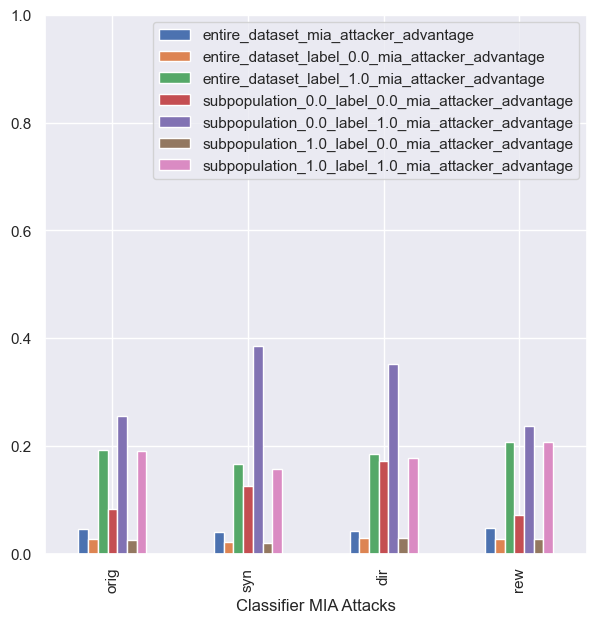

In [125]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [126]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}

In [127]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5591552675785937],
 ['orig', 'entire_dataset', 0.5854025583145223],
 ['orig', 'entire_dataset', 0.5854025583145223],
 ['orig', 'entire_dataset_label_0.0', 0.5463858850313034],
 ['orig', 'entire_dataset_label_0.0', 0.5692216280451574],
 ['orig', 'entire_dataset_label_0.0', 0.5692216280451574],
 ['orig', 'entire_dataset_label_1.0', 0.6278713629402757],
 ['orig', 'entire_dataset_label_1.0', 0.6155572176514585],
 ['orig', 'entire_dataset_label_1.0', 0.6155572176514585],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5408805031446541],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5783132530120483],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5783132530120483],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6923076923076923],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6103896103896105],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6103896103896105],
 ['orig', 'subpopulation_1.0_label_0.0', 0.5466467958271236],
 ['orig', 'subpopulation_1.0_label_0.0', 0.56875],
 ['orig', 'sub

In [128]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.559155
1,orig,entire_dataset,0.585403
2,orig,entire_dataset,0.585403
3,orig,entire_dataset_label_0.0,0.546386
4,orig,entire_dataset_label_0.0,0.569222
...,...,...,...
79,dir,subpopulation_1.0_label_0.0,0.544070
80,dir,subpopulation_1.0_label_0.0,0.544070
81,dir,subpopulation_1.0_label_1.0,0.620642
82,dir,subpopulation_1.0_label_1.0,0.612717


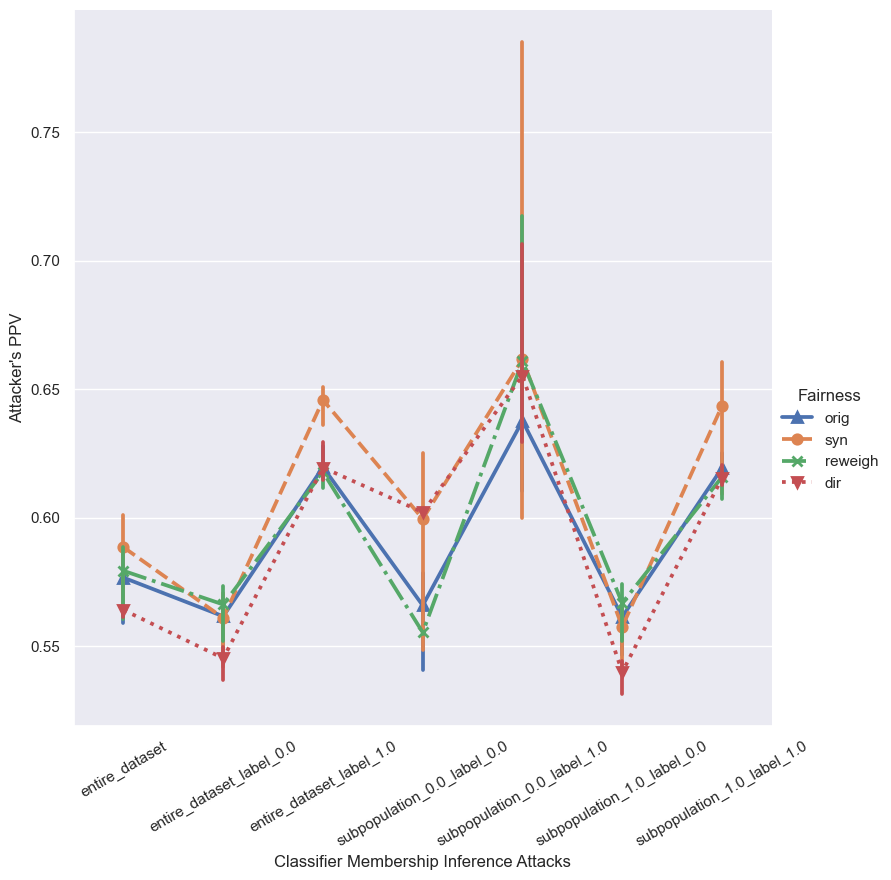

In [129]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [130]:
import pandas as pd

In [131]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,1.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30484,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30485,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30486,1.0,442.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [132]:
df[["age", "labels"]].value_counts(normalize=True)

age  labels
1.0  0.0       0.851614
1.0  1.0       0.120047
0.0  0.0       0.021812
0.0  1.0       0.006527
Name: proportion, dtype: float64

In [133]:
df.drop_duplicates()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,1.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30484,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30485,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30486,1.0,442.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
